Se recomienda que este código se ejecute con un Kernel de una GPU.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

tf.__version__

'2.8.0'

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Usamos un text limpiado y convertido a vocabulario. IMDB reviews subwords8k. El dataset ya está tokenizados a un embedding de 8000 palabras.

# Encoding

In [ ]:
encoder = info.features['text'].encoder
encoder.vocab_size

8185

In [ ]:
encoded = encoder.encode("Hello how are you today.")
encoded

[4025, 222, 113, 29, 37, 1076, 7975]

In [ ]:
[' ---> '.join([str(index),encoder.decode([index])]) for index in encoded]

['4025 ---> Hell',
 '222 ---> o ',
 '113 ---> how ',
 '29 ---> are ',
 '37 ---> you ',
 '1076 ---> today',
 '7975 ---> .']

# Batching


In [ ]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64

-*BUFFER_SIZE* : representa el número de observaciones individuales que queremos mezclar (shuffle). Para un correcto shuffle lo mejor es que sea mayor que el número de datos de los que partimos.

-*BATCH_SIZE*: Número de observaciones que se van a utilizar para entrenar el modelo en lotes.

A continuación mezclamos aleatoriamente el training dataset

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

Cogemos una muestra

In [ ]:
train_dataset = train_dataset.take(10000)
test_dataset = test_dataset.take(3000)

In [ ]:

train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<TakeDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [ ]:

train_dataset

<PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Our vectorized labels
#y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
#y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

El tamaño del batch es un hiperparámetros con el que se puede jugar para mejorar las predicciones. Generalmente va de valores de 32 a 256.

#  Compilar y entrenar el modelo
A continuación, usaremos una bidirectional LSTM, de manera que contectan 2 capas en ambas direcciones. A continuación mostramos la diferencia entre una única y una capa bidireccional. Esto permite  a nuestra RNN aprender hacia adelante y hacia atrás en una oración.

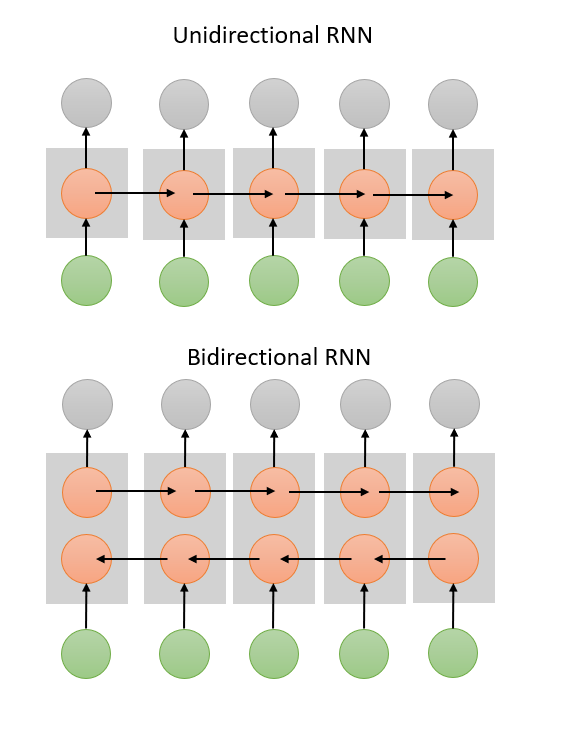



Como métrica, usamos la BinaryCrossEntropy, indicada para clasificar datos en 2 posibles clases: negativo y positivo.

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=encoder.vocab_size,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='softmax')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


157/157 [==============================] - 30s 105ms/step - loss: 0.6928 - accuracy: 0.5022
Epoch 2/50
157/157 [==============================] - 17s 101ms/step - loss: 0.6873 - accuracy: 0.5051
Epoch 3/50
157/157 [==============================] - 18s 104ms/step - loss: 0.5844 - accuracy: 0.4970
Epoch 4/50
157/157 [==============================] - 17s 101ms/step - loss: 0.3873 - accuracy: 0.4986
Epoch 5/50
157/157 [==============================] - 17s 104ms/step - loss: 0.2989 - accuracy: 0.4977
Epoch 6/50
157/157 [==============================] - 17s 104ms/step - loss: 0.2618 - accuracy: 0.4994
Epoch 7/50
157/157 [==============================] - 22s 130ms/step - loss: 0.2373 - accuracy: 0.4999
Epoch 8/50
157/157 [==============================] - 17s 103ms/step - loss: 0.2206 - accuracy: 0.5028
Epoch 9/50
157/157 [==============================] - 17s 103ms/step - loss: 0.1960 - accuracy: 0.4974
Epoch 10/50
157/157 [==============================] - 16s 97ms/step - loss: 0.1937 

In [ ]:
model.evaluate(test_dataset)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


47/47 [==============================] - 6s 60ms/step - loss: 0.6256 - accuracy: 0.5017


[0.6255912780761719, 0.5016666650772095]

Construímos una función que permita predecir una observación

In [ ]:
def sample_predict(sample_pred_text):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)  
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  return (sum(predictions[0]))

Veamos un ejemplo:

In [ ]:

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text)
predictions

1.0

In [ ]:
sample_pred_text = ('I hated this movie. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text)
predictions

1.0